### Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

### Load genome data

In [227]:
data, info = tfds.load("genomics_ood", with_info=True)

In [278]:
# We take 100,000 examples from our training data 
# and 1,000 examples from our test data
train = data['train'].take(100000)
test = data['test'].take(1000)


# Then we split the data into Input(sequence) and Label(bacteria)
train_sequence = np.array([example["seq"] for example in train])
train_label = np.array([example["label"] for example in train])

test_sequence = np.array([example["seq"] for example in test])
test_label = np.array([example["label"] for example in test])

### Inspect the data

In [279]:
print(train_sequence[0],"\n")
print(train_label[0])
   

tf.Tensor(b'AAACTATGTTATATTCACGATGATTAACTTACAAAGGAGTTTCAACTATGAAGATGATAAACAAATTAATCGTTCCGGTAACAGCTAGTGCTTTATTATTAGGCGCTTGTGGCGCTAGTGCCACAGACTCTAAAGAAAATACATTAATTTCTTCTAAAGCTGGAGACGTAACAGTTGCAGATACAATGAAAAAAATCGGTAAAGATCAAATTGCAAATGCATCATTTACTGAAATGTTAAATAAAATTTT', shape=(), dtype=string) 

7


### Encode sequences and labels

In [280]:
def onehotify(tensor):
    vocab ={"A": "1", "C": "2", "G": "3", "T": "0"}
    for key in vocab.keys():
        tensor = tf.strings.regex_replace(tensor, key, vocab[key])
    split = tf.strings.bytes_split(tensor)
    labels = tf.cast(tf.strings.to_number(split), tf.uint8)
    onehot = tf.one_hot(labels, 4)
    onehot = tf.reshape(onehot, (-1,))
    return onehot

In [281]:
train_sequence = [onehotify(seq) for seq in train_sequence]
train_label = [tf.one_hot(label, 10) for label in train_label]

test_sequence = [onehotify(seq) for seq in test_sequence]
test_label = [tf.one_hot(label, 10) for label in test_label]

In [282]:
train_sequence = tf.data.Dataset.from_tensor_slices(train_sequence)
train_label = tf.data.Dataset.from_tensor_slices(train_label)

test_sequence = tf.data.Dataset.from_tensor_slices(test_sequence)
test_label = tf.data.Dataset.from_tensor_slices(test_label)

### Zip together input and labels

In [283]:
train_dataset = tf.data.Dataset.zip((train_sequence, train_label))
train_dataset = train_dataset.batch(1000)
train_dataset = train_dataset.shuffle(buffer_size=1000)

test_dataset = tf.data.Dataset.zip((test_sequence, test_label))
test_dataset = train_dataset.batch(1000)
test_dataset = train_dataset.shuffle(buffer_size=1000)

### Build Model

In [284]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        # Define the three layers.
        self.hidden_layer_1 = tf.keras.layers.Dense(units=256,
                                               activation=tf.keras.activations.sigmoid
                                               )
        self.hidden_layer_2 = tf.keras.layers.Dense(units=256,
                                               activation=tf.keras.activations.sigmoid
                                               )
        self.output_layer = tf.keras.layers.Dense(units=10,
                                               activation=tf.keras.activations.softmax
                                               )
    def call(self, x):
        # Define the forward step.
        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        x = self.output_layer(x)
        return x

### Train the model

In [285]:
def train_step(model, input, target, loss_function, optimizer):
    # loss_object and optimizer_object are instances of respective tensorflow classes
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss 

def test(model, test_data, loss_function):
    # test over complete test data
    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

    test_loss = np.mean(test_loss_aggregator)
    test_accuracy = np.mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

In [286]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 10
learning_rate = 0.1
running_average_factor = 0.95

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_dataset = train_dataset.shuffle(buffer_size=128)
    test_dataset = test_dataset.shuffle(buffer_size=128)

    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)



Epoch: __ 0
Epoch: __ 1
Epoch: __ 2
Epoch: __ 3
Epoch: __ 4
Epoch: __ 5
Epoch: __ 6
Epoch: __ 7
Epoch: __ 8
Epoch: __ 9


### Visualize the training progress

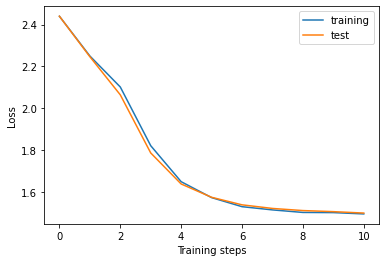

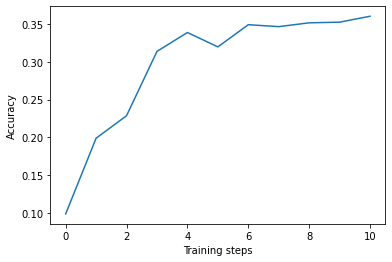

In [287]:
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()
